In [118]:
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load Data

In [ ]:
with open('../src/data/super_cleaned_mta_data_march.pickle', 'rb') as read_file:
    raw = pickle.load(read_file)
    
raw.head()


# 2. Add Weekday

In [41]:
raw['weekday'] = raw.start_datetime.dt.weekday < 5


In [44]:
raw.head(10)


,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries,weekday
1,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,2019-02-23 07:00:00,04:00:00,11.000000,False
2,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,2019-02-23 11:00:00,04:00:00,60.000000,False
3,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,2019-02-23 15:00:00,04:00:00,160.000000,False
4,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,2019-02-23 19:00:00,04:00:00,290.000000,False
5,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,2019-02-23 23:00:00,04:00:00,143.000000,False
6,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,2019-02-23 23:59:59,00:59:59,7.497917,False
7,A002,R051,02-00-00,59 ST,2019-02-24 03:00:00,2019-02-24 07:00:00,04:00:00,7.000000,False
8,A002,R051,02-00-00,59 ST,2019-02-24 07:00:00,2019-02-24 11:00:00,04:00:00,31.000000,False
9,A002,R051,02-00-00,59 ST,2019-02-24 11:00:00,2019-02-24 15:00:00,04:00:00,100.000000,False
10,A002,R051,02-00-00,59 ST,2019-02-24 15:00:00,2019-02-24 19:00:00,04:00:00,157.000000,False


In [159]:
len(raw.STATION.unique())

378

# 2. Explore Station Deviation

In [66]:
by_window = raw.groupby(['STATION', 'weekday', raw.start_datetime.dt.hour, raw.end_datetime.dt.hour]).agg({ 'entries': ['sum', 'count'] }).reset_index()

In [67]:
by_window.columns = ['_'.join(col).strip() for col in by_window.columns.values]
by_window = by_window.rename(columns={
    'STATION_': 'station',
    'start_datetime_': 'start_datetime',
    'end_datetime_': 'end_datetime',
    'weekday_': 'weekday'
})


In [68]:
by_window.head(10)


,station,weekday,start_datetime,end_datetime,entries_sum,entries_count
0,1 AV,False,0,3,342.0,40
1,1 AV,False,0,4,1763.0,50
2,1 AV,False,3,7,2.0,50
3,1 AV,False,4,8,405.0,50
4,1 AV,False,7,11,5.0,50
5,1 AV,False,8,12,2849.0,50
6,1 AV,False,11,15,10.0,50
7,1 AV,False,12,16,6204.0,50
8,1 AV,False,15,19,12.0,50
9,1 AV,False,16,20,6966.0,50


In [80]:
def get_time_of_day(row):
    if (row.start_datetime >= 2) and (row.end_datetime <= 9):
        return 'early_morning'
    elif (row.start_datetime >= 6) and (row.end_datetime <= 13):
            return 'late_morning'
    elif (row.start_datetime >= 10) and (row.end_datetime <= 17):
            return 'afternoon'
    elif (row.start_datetime >= 14) and (row.end_datetime <= 21):
            return 'evening'
    else:
        return 'other'

by_window['time_of_day'] = by_window.apply(get_time_of_day, axis=1)


In [81]:
by_window.head()


,station,weekday,start_datetime,end_datetime,entries_sum,entries_count,time_of_day
0,1 AV,False,0,3,342.0,40,other
1,1 AV,False,0,4,1763.0,50,other
2,1 AV,False,3,7,2.0,50,early_morning
3,1 AV,False,4,8,405.0,50,early_morning
4,1 AV,False,7,11,5.0,50,late_morning


In [86]:
by_window.groupby(['station', 'weekday', 'time_of_day']).agg({ 'entries_sum': 'sum'}).reset_index()


,station,weekday,time_of_day,entries_sum
0,1 AV,False,afternoon,6214.000000
1,1 AV,False,early_morning,407.000000
2,1 AV,False,evening,6978.000000
3,1 AV,False,late_morning,2854.000000
4,1 AV,False,other,6781.723090
...,...,...,...,...
3775,ZEREGA AV,True,afternoon,13759.000000
3776,ZEREGA AV,True,early_morning,27054.000000
3777,ZEREGA AV,True,evening,9780.000000
3778,ZEREGA AV,True,late_morning,14797.000000


In [101]:
diff = raw.start_datetime.max() - raw.start_datetime.min()
days_in_data_set = diff.total_seconds() / (3600 * 24)

by_window['days_observed'] = by_window.groupby(['station', 'weekday'])['start_datetime'].transform(lambda gp: gp.max() - gp.min())
by_window['entries_per_day'] = by_window['entries_sum'] / by_window['days_observed']



In [106]:
by_time_of_day = by_window.groupby(['station', 'weekday', 'time_of_day']).agg({ 'entries_sum': 'sum', 'days_observed': 'mean' }).reset_index()

In [112]:
by_time_of_day['avg_entries'] = by_time_of_day['entries_sum'] / by_time_of_day['days_observed']


In [161]:
by_time_of_day.head(30)


,station,weekday,time_of_day,entries_sum,days_observed,entries_per_day,avg_entries
0,1 AV,False,afternoon,6214.000000,23,270.173913,270.173913
1,1 AV,False,early_morning,407.000000,23,17.695652,17.695652
2,1 AV,False,evening,6978.000000,23,303.391304,303.391304
3,1 AV,False,late_morning,2854.000000,23,124.086957,124.086957
4,1 AV,False,other,6781.723090,23,294.857526,294.857526
5,1 AV,True,afternoon,100097.000000,23,4352.043478,4352.043478
6,1 AV,True,early_morning,26762.000000,23,1163.565217,1163.565217
7,1 AV,True,evening,157308.000000,23,6839.478261,6839.478261
8,1 AV,True,late_morning,124788.000000,23,5425.565217,5425.565217
9,1 AV,True,other,87743.154028,23,3814.919740,3814.919740


The max is ~5 people per second (which seems reasonable)

# Plot Single Station

In [136]:
by_time_of_day.station.sample(10)


2303           GRAND ST
3303        ROCKAWAY AV
3600     VAN SICLEN AVE
1725        BUSHWICK AV
1996          DEKALB AV
957                7 AV
2797    METS-WILLETS PT
2788    METROPOLITAN AV
2335    GRD CNTRL-42 ST
2573    JKSN HT-ROOSVLT
Name: station, dtype: object

In [171]:
station_name = 'TIMES SQ-42 ST'

weekday = by_time_of_day[(by_time_of_day.station == station_name) & by_time_of_day.weekday]
weekend = by_time_of_day[(by_time_of_day.station == station_name) & (~by_time_of_day.weekday)]



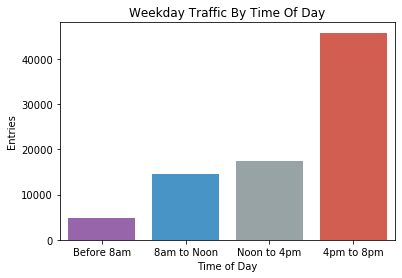

In [190]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

ax = sns.barplot(
    x='time_of_day',
    y='avg_entries',
    data=weekday,
    order=['early_morning', 'late_morning', 'afternoon', 'evening'],
    palette = sns.color_palette(flatui)
)
ax.set_title('Weekday Traffic By Time Of Day')
ax.set(
    xticklabels=['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'],
    xlabel='Time of Day',
    ylabel='Entries'
);

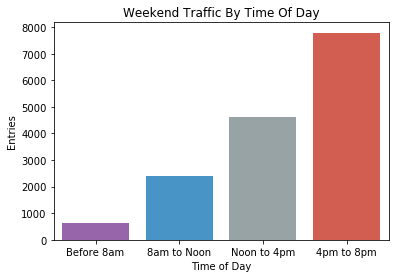

In [189]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

ax = sns.barplot(
    x='time_of_day',
    y='avg_entries',
    data=weekend,
    order=['early_morning', 'late_morning', 'afternoon', 'evening'],
    palette = sns.color_palette(flatui)
)
ax.set_title('Weekend Traffic By Time Of Day')
ax.set(
    xticklabels=['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'],
    xlabel='Time of Day',
    ylabel='Entries'
);


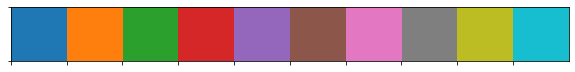

In [174]:
current_palette = sns.color_palette()
sns.palplot(current_palette)




## Graph All Top Twenty

In [278]:
# top_20 = [
#     '34 ST-PENN STA',
#      'GRD CNTRL-42 ST',
# #      '34 ST-HERALD SQ',
# #      '23 ST',
#      '42 ST-PORT AUTH',
#      '14 ST-UNION SQ',
#      'TIMES SQ-42 ST',
#      'FULTON ST',
#      '86 ST',
#      '125 ST',
#      'CANAL ST',
#      '59 ST COLUMBUS',
#      '59 ST',
#      '14 ST',
#      '96 ST',
#      'CHAMBERS ST',
#      'FLUSHING-MAIN',
#      '47-50 STS ROCK',
#      'JKSN HT-ROOSVLT',
#      '50 ST'
# ]
top_20 = ['CHAMBERS ST', 'GRD CNTRL-42 ST', 'FULTON ST', '47-50 STS ROCK', '23 ST', '34 ST-PENN STA']
# remove = grand_central, fulton st, chamber st, 47th st, penn st, 23rd

In [279]:
top_20_weekday = by_time_of_day[(by_time_of_day.station.isin(top_20)) & by_time_of_day.weekday & (by_time_of_day.time_of_day != 'other')]

In [280]:
top_20_weekday.head()

,station,weekday,time_of_day,entries_sum,days_observed,entries_per_day,avg_entries
465,23 ST,True,afternoon,635302.0,23,27621.826087,27621.826087
466,23 ST,True,early_morning,135008.0,23,5869.913043,5869.913043
467,23 ST,True,evening,1256497.0,23,54630.304348,54630.304348
468,23 ST,True,late_morning,504041.0,23,21914.826087,21914.826087
615,34 ST-PENN STA,True,afternoon,645467.0,23,28063.782609,28063.782609


In [281]:
top_20_weekday['total'] = top_20_weekday.groupby(['station'])['avg_entries'].transform('sum')

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [282]:
top_20_weekday['percent'] = top_20_weekday['avg_entries'] / top_20_weekday['total']

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [283]:
top_20_weekday.head()

,station,weekday,time_of_day,entries_sum,days_observed,entries_per_day,avg_entries,total,percent
465,23 ST,True,afternoon,635302.0,23,27621.826087,27621.826087,110036.869565,0.251023
466,23 ST,True,early_morning,135008.0,23,5869.913043,5869.913043,110036.869565,0.053345
467,23 ST,True,evening,1256497.0,23,54630.304348,54630.304348,110036.869565,0.496473
468,23 ST,True,late_morning,504041.0,23,21914.826087,21914.826087,110036.869565,0.199159
615,34 ST-PENN STA,True,afternoon,645467.0,23,28063.782609,28063.782609,158921.347826,0.176589


In [284]:
by_percent = top_20_weekday.pivot(index='station', columns='time_of_day', values='percent').reset_index()

In [285]:
by_percent.head()

time_of_day,station,afternoon,early_morning,evening,late_morning
0,23 ST,0.251023,0.053345,0.496473,0.199159
1,34 ST-PENN STA,0.176589,0.144060,0.289801,0.389550
2,47-50 STS ROCK,0.201386,0.011127,0.723453,0.064034
3,CHAMBERS ST,0.266014,0.027572,0.551696,0.154718
4,FULTON ST,0.233391,0.082129,0.514495,0.169985


In [286]:
by_percent['total_perc'] = by_percent.afternoon + by_percent.early_morning + by_percent.evening + by_percent.late_morning

In [287]:
by_percent['total_morn'] = by_percent.early_morning + by_percent.late_morning
by_percent['total_aft'] = by_percent.afternoon + by_percent.evening
by_percent = by_percent.sort_values(['total_morn', 'total_aft'])

In [288]:
by_percent.head()

time_of_day,station,afternoon,early_morning,evening,late_morning,total_perc,total_morn,total_aft
2,47-50 STS ROCK,0.201386,0.011127,0.723453,0.064034,1.0,0.075161,0.924839
3,CHAMBERS ST,0.266014,0.027572,0.551696,0.154718,1.0,0.182290,0.817710
4,FULTON ST,0.233391,0.082129,0.514495,0.169985,1.0,0.252114,0.747886
0,23 ST,0.251023,0.053345,0.496473,0.199159,1.0,0.252504,0.747496
5,GRD CNTRL-42 ST,0.212937,0.094201,0.473486,0.219376,1.0,0.313577,0.686423


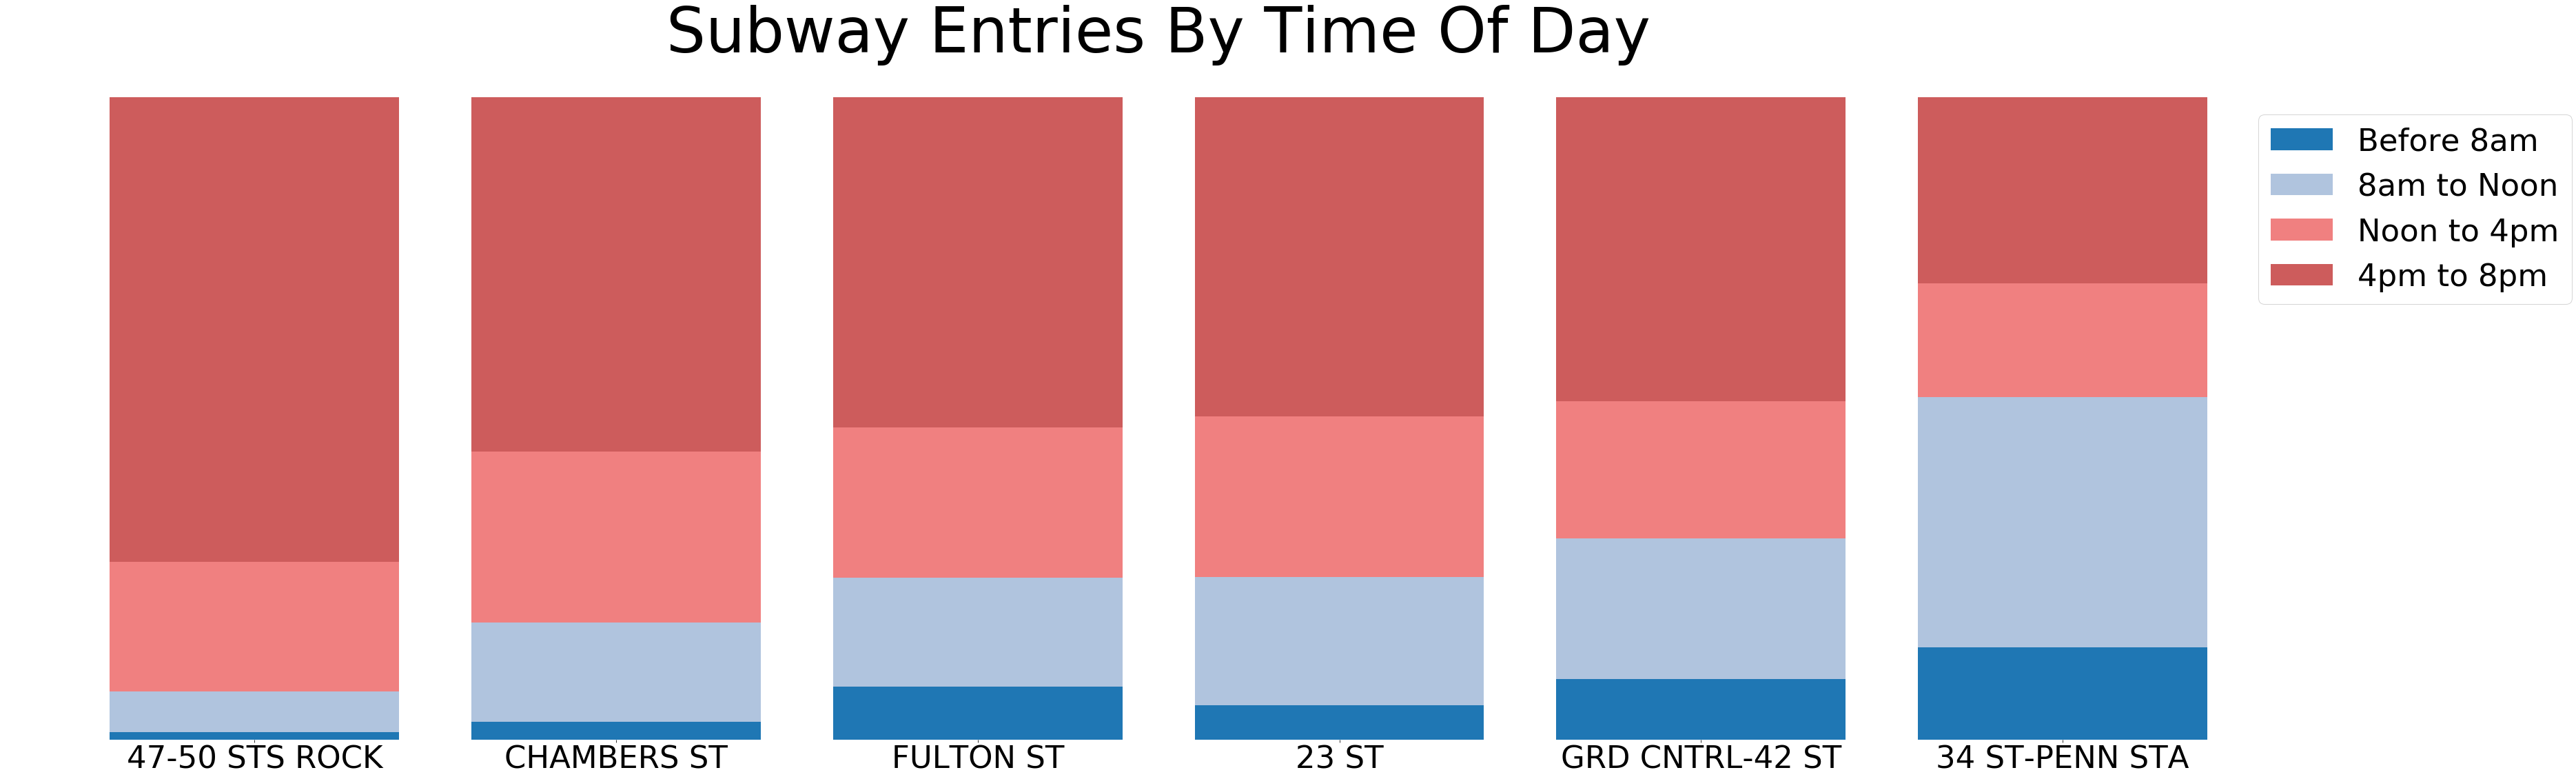

In [324]:
plt.figure(figsize=(60, 18))
ax = plt.bar(by_percent.station, by_percent.early_morning, color='tab:blue')
plt.bar(by_percent.station, by_percent.late_morning, bottom=by_percent.early_morning, color='lightsteelblue')
plt.bar(by_percent.station, by_percent.afternoon, bottom=(by_percent.early_morning + by_percent.late_morning), color='lightcoral')
plt.bar(by_percent.station, by_percent.evening, bottom=(by_percent.early_morning + by_percent.late_morning + by_percent.afternoon), color='indianred')
# plt.xticks(rotation='30')
plt.legend(['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'], bbox_to_anchor=(0.97, .95), fontsize='45')
plt.title('Subway Entries By Time Of Day', fontsize='90')
plt.xticks(fontsize='45')
plt.yticks([])
plt.box(on=None)
# legend()
plt.savefig('../src/visualization/top_station_by_time_of_day.jpg', format='jpg', quality=95, pad_inches=17)

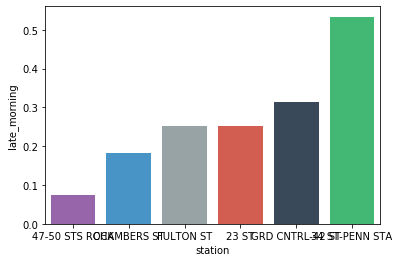

In [290]:
sns.barplot(
    x=by_percent['station'],
    y='early_morning',
    data=by_percent,
    palette = sns.color_palette(flatui),
    label=''
)
sns.barplot(
    x=by_percent['station'],
    y='late_morning',
    data=by_percent,
    palette = sns.color_palette(flatui),
    bottom=by_percent['early_morning']
)
# sns.barplot(
#     x='station',
#     y='afternoon',
#     data=by_percent,
#     palette = sns.color_palette(flatui),
# )
# sns.barplot(
#     x='station',
#     y='evening',
#     data=by_percent,
#     palette = sns.color_palette(flatui),
# )
# ax.set_title(f'{station_name} Weekday Traffic By Time Of Day')
# ax.set(
#     xticklabels=['Before 8am', '8am to Noon', 'Noon to 4pm', '4pm to 8pm'],
#     xlabel='Time of Day',
#     ylabel='Entries'
# );